In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.rcParams['font.size']=18
matplotlib.rcParams['xtick.labelsize']=18
matplotlib.rcParams['ytick.labelsize']=18

import numpy as np
import pandas as pd

from sqlalchemy import create_engine

%load_ext line_profiler

In [2]:
from app import model

In [3]:
user='gshau'
host='localhost'
dbname='birth_db'

dbname = 'ncaabb'
username = 'gshau' # change this to your username
engine = create_engine('postgres://%s@localhost/%s'%(username,dbname))

years = model.getYears()
year=2017
pointsByRound=[1,2,4,8,16,32]

In [4]:
def runPoolSim(year=2017,risk=0.3):
    t=model.Tournament(year)
    pool=model.Pool(t,poolSize=25,pointSystem=dict([(i+2, pointsByRound[i]) for i in np.arange(6)]),risk=risk)
    pool.loadTourneySets()
    print('----', year, '----')
    sim=[]
    simrank=[]
    real=[]
    realrank=[]
    poolList=[]
    for rep in range(20):
        pool.simulatePool(useRealBracket=False,verbose=False,nrep=20)
        poolList.append(pool)
    return poolList


In [6]:
%time poolList=runPoolSim(year=2008)

Load: Tournament length:  1000
---- 2008 ----
CPU times: user 1.69 s, sys: 25.1 ms, total: 1.72 s
Wall time: 1.73 s


In [8]:
yearList=np.arange(2017,2003,-1)
for yr in yearList:
    print(yr)
    t=model.Tournament(yr)
    pool=model.Pool(t,poolSize=25,pointSystem=dict([(i+2, pointsByRound[i]) for i in np.arange(6)]))
    pool.getTourneySets(ntourney=1000,scaleFactor=0.481)  

2017
Save: Tournament length:  1000
2016
Save: Tournament length:  1000
2015
Save: Tournament length:  1000
2014
Save: Tournament length:  1000
2013
Save: Tournament length:  1000
2012
Save: Tournament length:  1000
2011
Save: Tournament length:  1000
2010
Save: Tournament length:  1000
2009
Save: Tournament length:  1000
2008
Save: Tournament length:  1000
2007
Save: Tournament length:  1000
2006
Save: Tournament length:  1000
2005
Save: Tournament length:  1000
2004
Save: Tournament length:  1000


Check performance of function

In [9]:
%lprun -f p.simulatePool runPoolSim()

Load: Tournament length:  1000
---- 2017 ----


Run back-testing vs. previous 13 years.  Vary the risk level to check against expected payouts and ranks.

In [10]:
yearList=np.arange(2017,2003,-1)
nPools=100
real={}
sim={}
realrank={}
simrank={}
riskList=[0.2,0.4,0.6,0.8,1.]
# riskList=[0.4]
for risk in riskList:
    real[risk]={}
    sim[risk]={}
    realrank[risk]={}
    simrank[risk]={}
    for year in yearList:
        real[risk][year]=[]
        sim[risk][year]=[]
        realrank[risk][year]=[]
        simrank[risk][year]=[]
        t=model.Tournament(year)
        pool=model.Pool(t,poolSize=25,pointSystem=dict([(i+2, pointsByRound[i]) for i in np.arange(6)]),risk=risk)
        pool.loadTourneySets()
        print('----', year, '----')

        for rep in range(nPools):
            pool.simulatePool(useRealBracket=False,verbose=False,nrep=20)
            sim[risk][year].append(list(pool.summary['expPayout']))
            simrank[risk][year].append(pool.summary['ranks'])
            pool.simulatePool(useRealBracket=True,verbose=False,nrep=20)
            real[risk][year].append(list(pool.summary['expPayout']))
            realrank[risk][year].append(pool.summary['ranks'])

            

Load: Tournament length:  1000
---- 2017 ----
Load: Tournament length:  1000
---- 2016 ----
Load: Tournament length:  1000
---- 2015 ----
Load: Tournament length:  1000
---- 2014 ----
Load: Tournament length:  1000
---- 2013 ----
Load: Tournament length:  1000
---- 2012 ----
Load: Tournament length:  1000
---- 2011 ----
Load: Tournament length:  1000
---- 2010 ----
Load: Tournament length:  1000
---- 2009 ----
Load: Tournament length:  1000
---- 2008 ----
Load: Tournament length:  1000
---- 2007 ----
Load: Tournament length:  1000
---- 2006 ----
Load: Tournament length:  1000
---- 2005 ----
Load: Tournament length:  1000
---- 2004 ----
Load: Tournament length:  1000
---- 2017 ----
Load: Tournament length:  1000
---- 2016 ----
Load: Tournament length:  1000
---- 2015 ----
Load: Tournament length:  1000
---- 2014 ----
Load: Tournament length:  1000
---- 2013 ----
Load: Tournament length:  1000
---- 2012 ----
Load: Tournament length:  1000
---- 2011 ----
Load: Tournament length:  1000
---

Output final rank heatmap from back-testing to images

In [9]:
for year in yearList:
    for riskValue in [0.2,0.4,0.6,0.8,1]:
        rankingArray=np.array(realrank[riskValue][year]).sum(axis=0).T
#         plt.figure()
        plt.imshow(rankingArray,origin='lower')
        plt.colorbar()
        plt.title('Back-testing '+str(year)+ ', risk = '+str(riskValue))
        plt.xlabel('First bracket ranking')
        plt.ylabel('Second bracket ranking')
        plt.savefig('backtest_heatmaps/backtest_heatmaps-'+str(year)+'-r_'+str(riskValue*10).zfill(2)+'.png')
        plt.clf()

Show stability of expected payout by iteration of pool simulation

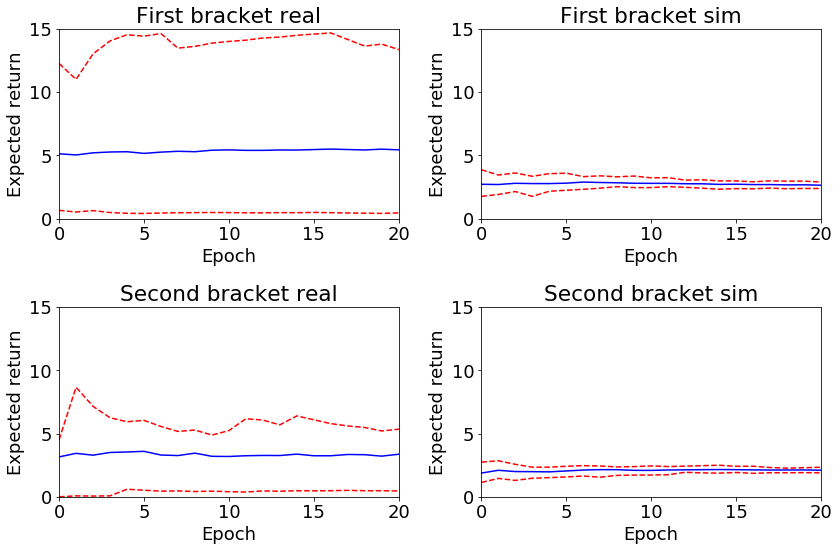

In [10]:
ymax=15
xmax=20

yearList=np.arange(2017,2003,-1)

risk=0.4

norm=(np.arange(nPools)+1)

plt.subplot(2,2,1)
dist=np.array([np.array(real[risk][year])[:,0].cumsum()/norm
                   for year in yearList])
plt.plot(dist.mean(axis=0),'b')
plt.plot(np.percentile(dist,16,axis=0),'r--')
plt.plot(np.percentile(dist,84,axis=0),'r--')
plt.ylim(0,ymax)
plt.xlim(0,xmax)
plt.title('First bracket real')
plt.ylabel('Expected return')
plt.xlabel('Epoch')

plt.subplot(2,2,2)
dist=np.array([np.array(sim[risk][year])[:,0].cumsum()/norm
                   for year in yearList])
plt.plot(dist.mean(axis=0),'b')
plt.plot(np.percentile(dist,16,axis=0),'r--')
plt.plot(np.percentile(dist,84,axis=0),'r--')
plt.ylim(0,ymax)
plt.xlim(0,xmax)
plt.title('First bracket sim')
plt.ylabel('Expected return')
plt.xlabel('Epoch')


plt.subplot(2,2,3)
dist=np.array([np.array(real[risk][year])[:,1].cumsum()/norm
                   for year in yearList])
plt.plot(dist.mean(axis=0),'b')
plt.plot(np.percentile(dist,16,axis=0),'r--')
plt.plot(np.percentile(dist,84,axis=0),'r--')
plt.ylim(0,ymax)
plt.xlim(0,xmax)
plt.title('Second bracket real')
plt.ylabel('Expected return')
plt.xlabel('Epoch')

plt.subplot(2,2,4)
dist=np.array([np.array(sim[risk][year])[:,1].cumsum()/norm
                   for year in yearList])
plt.plot(dist.mean(axis=0),'b')
plt.plot(np.percentile(dist,16,axis=0),'r--')
plt.plot(np.percentile(dist,84,axis=0),'r--')
plt.ylim(0,ymax)
plt.xlim(0,xmax)
plt.title('Second bracket sim')
plt.ylabel('Expected return')
plt.xlabel('Epoch')
plt.tight_layout()


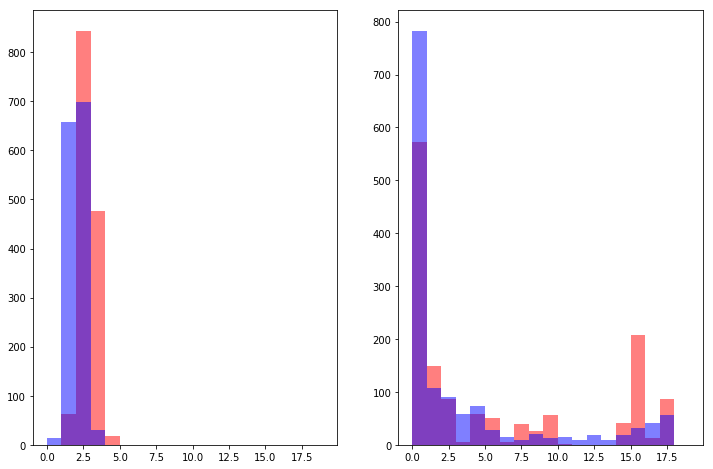

In [36]:
plt.subplot(1,2,1)
plt.hist(np.array([np.array(sim[year])[:,0] for year in np.arange(2017,2003,-1)]).flatten(),bins=range(20),color=[1,0,0,0.5]);
plt.hist(np.array([np.array(sim[year])[:,1] for year in np.arange(2017,2003,-1)]).flatten(),bins=range(20),color=[0,0,1,0.5]);
plt.subplot(1,2,2)

plt.hist(np.array([np.array(real[year])[:,0] for year in np.arange(2017,2003,-1)]).flatten(),bins=range(20),color=[1,0,0,0.5]);
plt.hist(np.array([np.array(real[year])[:,1] for year in np.arange(2017,2003,-1)]).flatten(),bins=range(20),color=[0,0,1,0.5]);